# Enzyme-Substrate Interaction (ESI) Prediction

<img src="https://raw.githubusercontent.com/lfsalasnu/Specific_CPI/main/Problem_general.png" alt="Figura 1" width="800"/>

In [ ]:
# This code is based on the article:
# EnZymClass: Substrate specificity prediction tool of plant acyl-ACP thioesterases based on ensemble learning
# DOI: https://doi.org/10.1016/j.crbiot.2021.12.002
# DOI: https://zenodo.org/records/5032482

## Introduction

### Specific problem

Find the enzyme that catalyzes the reaction:






### Machine Learning Model

<img src="https://raw.githubusercontent.com/lfsalasnu/Specific_CPI/main/Model.png" alt="Figura 2" width="800"/>

## Features

### Preprocessing

#### Initials

##### Installing and calling libraries

In [ ]:
!pip install ifeatpro
!pip install ngrampro
!pip install pssmpro

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [ ]:
# feature encoding
import pandas as pd
import os
import ifeatpro.features as ipro
import pssmpro.features as ppro
import ngrampro as npro
from scipy import sparse, io
import numpy as np

##### Upload files

Upload the compressed data file, this must contain the training sequences and search space sequences in the 'data/raw/' address. It must also contain the utils folder where the 'Kernels-KeBABs.r' file is located, which will be used to calculate the kernel-based descriptors.

Example: TE.zip

In [ ]:
# Uploded Data
from google.colab import files
import zipfile

uploaded=files.upload()
archivo_zip=list(uploaded.keys())[0]
with zipfile.ZipFile(archivo_zip, 'r') as zip_ref:
    zip_ref.extractall('./')

Saving CYP.zip to CYP.zip


##### Training data

In [ ]:
# change the data names, if you only have one dataset split it into training and search space data
file_train="CYP/CYP_trainset"
file_search_space="CYP/CYP_search_space"
#file_test="TE_testset.csv"

In [ ]:
search_space_raw="./data/raw/" + file_search_space + ".csv"
train_raw="./data/raw/" + file_train + ".csv"
df_search_space = pd.read_csv(search_space_raw, header=None, names=["enz_name", "enz_seq"])
df_train = pd.read_csv(train_raw, header=None, names=["enz_name", "enz_seq", "enz_label"])
print(f'The number of enzymatic sequences to train the model is: {len(df_train)}')
print(f'The number of enzymatic sequences to search space is: {len(df_search_space)}')
df_search_space.head(2)
df_train.head(2)

The number of enzymatic sequences to train the model is: 100
The number of enzymatic sequences to search space is: 100


,enz_name,enz_seq,enz_label
0,sp|P92994|TCMO_ARATH,MDLLLLEKSLIAVFVAVILATVISKLRGKKLKLPPGPIPIPIFGNW...,1
1,sp|O49342|C71AD_ARATH,MEMILSISLCLTTLITLLLLRRFLKRTATKVNLPPSPWRLPVIGNL...,1


##### Raw data analysis
for easier downstream applications

In [ ]:
# parse raw file
# upper case all sequences
def up_seq(seq):
    return seq.upper().replace('-','')


df_train["enz_seq"] = df_train.enz_seq.apply(up_seq)
df_search_space["enz_seq"] = df_search_space.enz_seq.apply(up_seq)

# get rid of sequences with illegitimate amino acids
df_train = df_train.loc[~df_train["enz_seq"].str.contains('B|J|O|U|X|Z')]
df_search_space = df_search_space.loc[~df_search_space["enz_seq"].str.contains('B|J|O|U|X|Z')]

# create enzyme alias
enz_alias_train = [f'enz_{i}' for i in range(len(df_train['enz_name']))]
df_train = df_train.assign(enz_alias=enz_alias_train)
enz_alias_search_space = [f'search_space_enz_{i}' for i in range(len(df_search_space['enz_name']))]
df_search_space = df_search_space.assign(enz_alias=enz_alias_search_space)

# enzyme alias to original enzyme name mapping
folder='./analysis/mappings'
if not os.path.exists(folder):
    os.makedirs(folder)
enz_train_name_map = folder + "/train_enz_map.csv"
enz_search_space_name_map = folder + "/search_space_enz_map.csv"
df_train.loc[:, ["enz_alias", "enz_name"]].to_csv(enz_train_name_map, index=False, header=False)
df_search_space.loc[:, ["enz_alias", "enz_name"]].to_csv(enz_search_space_name_map, index=False, header=False)

# names in fasta
folder='./analysis/seq'
if not os.path.exists(folder):
    os.makedirs(folder)
enz_train_fasta = folder + "/train_enz.fa"
enz_search_space_fasta = folder + "/search_space_enz.fa"


train_fasta_stream = open(enz_train_fasta, 'w')
search_space_fasta_stream = open(enz_search_space_fasta, "w")

for value in df_train.loc[:, ["enz_alias", "enz_seq"]].values:
    train_fasta_stream.write(f">{value[0]}\n{value[1]}\n")

for value in df_search_space.loc[:, ["enz_alias", "enz_seq"]].values:
    search_space_fasta_stream.write(f">{value[0]}\n{value[1]}\n")

train_fasta_stream.close()
search_space_fasta_stream.close()

# create csv file of sequence
enz_train_csv = folder + "/train_enz.csv"
enz_search_space_csv = folder + "/search_space_enz.csv"
df_train.loc[:, ["enz_alias", "enz_seq"]].to_csv(enz_train_csv, header=False, index=False)
df_search_space.loc[:, ["enz_alias", "enz_seq"]].to_csv(enz_search_space_csv, header=False, index=False)

##### Creating labels

In [ ]:
# create labels as csv
folder='./analysis/label'
if not os.path.exists(folder):
    os.makedirs(folder)
train_labels = folder + "/train_enz_label.csv"
df_train.loc[:, ["enz_alias", "enz_label"]].to_csv(train_labels, index=False, header=False)

### Numerical coding of sequences (Descriptors)


The sequences are numerically encoded in 47 different ways. They are:

21 types of physicochemical encodings using the [ifeatpro](https://github.com/deeprob/ifeatpro).

21 types of PSSM-based encodings using the [pssmpro](https://pypi.org/project/pssmpro/).

2 types of ngram-based encodings using the [ngrampro](https://pypi.org/project/ngrampro/).

3 types of kernel-based encodings using an external tool written in R known as [KeBABS](https://bioconductor.org/packages/release/bioc/vignettes/kebabs/inst/doc/kebabs.pdf).



#### [Ifeatpro](https://github.com/deeprob/ifeatpro)
The ifeatpro link can be used directly with a fasta file containing protein sequences in fasta format.

In [ ]:
help(ipro.get_all_features)

Help on function get_all_features in module ifeatpro.features:

get_all_features(fasta_file, output_dir)
    A function to create 21 numerically encoded features for protein sequences
    :param fasta_file: The path to a file that contains all the protein sequences in fasta format
    :param output_dir: The path to a directory where the feature encoded files will be stored
    :return: None



In [ ]:
# Addresses
train_fasta_file = "./analysis/seq/train_enz.fa"
search_space_fasta_file = "./analysis/seq/search_space_enz.fa"

train_output_dir = "./analysis/features/ifeatpro/train/"
search_space_output_dir = "./analysis/features/ifeatpro/search_space/"

os.makedirs(train_output_dir, exist_ok=True)
os.makedirs(search_space_output_dir, exist_ok=True)

ipro.get_all_features(train_fasta_file, train_output_dir)
ipro.get_all_features(search_space_fasta_file, search_space_output_dir)

Descriptor type: aac
Descriptor type: cksaap
Descriptor type: tpc
Descriptor type: dpc
Descriptor type: dde
Descriptor type: gaac
Descriptor type: cksaagp
Descriptor type: gtpc
Descriptor type: gdpc
Descriptor type: moran
Descriptor type: geary
Descriptor type: nmbroto
Descriptor type: ctdc
Descriptor type: ctdt
Descriptor type: ctdd
Descriptor type: ctriad
Descriptor type: ksctriad
Descriptor type: socnumber
Descriptor type: qsorder
Descriptor type: paac
Descriptor type: apaac
Descriptor type: aac
Descriptor type: cksaap
Descriptor type: tpc
Descriptor type: dpc
Descriptor type: dde
Descriptor type: gaac
Descriptor type: cksaagp
Descriptor type: gtpc
Descriptor type: gdpc
Descriptor type: moran
Descriptor type: geary
Descriptor type: nmbroto
Descriptor type: ctdc
Descriptor type: ctdt
Descriptor type: ctdd
Descriptor type: ctriad
Descriptor type: ksctriad
Descriptor type: socnumber
Descriptor type: qsorder
Descriptor type: paac
Descriptor type: apaac


#### [Pssmpro](https://pypi.org/project/pssmpro/)

Pssmpro requires the pssm profile of protein sequences as input. At first, it is necessary to create the pssm profiles and then these profiles can be numerically encoded using the function provided by pssmpro. pssmpro also provides a function to create numerical encodings of protein sequences. The psiblast program path and an indexed blast database are required as function argument.



##### Creating pssm profiles

In [ ]:
help(ppro.create_pssm_profile)

Help on function create_pssm_profile in module pssmpro.features:

create_pssm_profile(seq_file, out_dir, psiblast_exec, database_prefix, num_threads=24)
    A function to create psiblast or pssm profile for protein sequences
    :param seq_file: A csv file with name of the protein followed by its sequence separated by a comma
    :param out_dir: The directory where the user would like to store the pssm profiles of all the sequences
    :param psiblast_exec: The path of the psiblast executable. psiblast program needs to be installed
    :param database_prefix: The path of the indexed blast database directory prefix
    :param num_threads: Number of threads to use while creating the psiblast profile
    :return: The output directory where the psiblast/pssm profiles are stored



###### Installation Blast and download database swissprot

In [ ]:
!pip install biopython #Install blast package
#download database to make blast
#linux, colab or macOS
!wget https://ftp.ncbi.nlm.nih.gov/blast/db/FASTA/swissprot.gz # linux or colab
#!wget ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/complete/uniprot_sprot.fasta.gz

#windows
#import urllib.request
#url = "https://ftp.ncbi.nlm.nih.gov/blast/db/FASTA/swissprot.gz"
#output_file = "swissprot.gz"
#urllib.request.urlretrieve(url, output_file)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 26.9 MB/s eta 0:00:00
--2025-05-05 18:22:42--  https://ftp.ncbi.nlm.nih.gov/blast/db/FASTA/swissprot.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.7, 130.14.250.10, 130.14.250.11, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143234298 (137M) [application/x-gzip]
Saving to: ‘swissprot.gz’

swissprot.gz        100%[===================>] 136.60M  65.9MB/s    in 2.1s    

2025-05-05 18:22:44 (65.9 MB/s) - ‘swissprot.gz’ saved [143234298/143234298]



In [ ]:
# linux or colab
!gunzip swissprot.gz
#!gunzip uniprot_sprot.fasta.gz
# windows
#import gzip
#import shutil

#with gzip.open('swissprot.gz', 'rb') as f_in:
#    with open('swissprot', 'wb') as f_out:
#        shutil.copyfileobj(f_in, f_out)

In [ ]:
# We install blast in the environment
!apt-get install ncbi-blast+
# You can also download the executables and run them.
#!wget ftp://ftp.ncbi.nlm.nih.gov/blast/executables/blast+/2.9.0/ncbi-blast-2.9.0+-x64-linux.tar.gz
# Unzip either of the two
#!tar -zxvf ncbi-blast-2.9.0+-x64-linux.tar.gz
#!gunzip ncbi-blast-2.9.0+-x64-linux.tar.gz
# We add it to the directory so that it can be executed
#os.environ['PATH'] += ":/content/ncbi-blast-2.9.0+/bin"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  ncbi-data
The following NEW packages will be installed:
  ncbi-blast+ ncbi-data
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 15.8 MB of archives.
After this operation, 71.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 ncbi-data all 6.1.20170106+dfsg1-9 [3,519 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 ncbi-blast+ amd64 2.12.0+ds-3build1 [12.3 MB]
Fetched 15.8 MB in 1s (13.1 MB/s)
Selecting previously unselected package ncbi-data.
(Reading database ... 126101 files and directories currently installed.)
Preparing to unpack .../ncbi-data_6.1.20170106+dfsg1-9_all.deb ...
Unpacking ncbi-data (6.1.20170106+dfsg1-9) ...
Selecting previously unselected package ncbi-blast+.
Preparing to unpack .../ncbi-blast+_2.12.0+ds-3build1_amd64.deb .

In [ ]:
# We generate the database for blast from the downloaded one
os.rename('swissprot', 'swissprot.fasta')
#!makeblastdb -in uniprot_sprot.fasta -dbtype prot -out ./db/sprot
!makeblastdb -in swissprot.fasta -dbtype prot -out ./db/swissprot



Building a new DB, current time: 05/05/2025 18:23:10
New DB name:   /content/db/swissprot
New DB title:  swissprot.fasta
Sequence type: Protein
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 482697 sequences in 18.7495 seconds.




###### Generating psiblast profile

In [ ]:
#database_pre = "db/sprot"
database_pre = "./db/swissprot"
train_seq_file = "./analysis/seq/train_enz.csv"
search_space_seq_file = "./analysis/seq/search_space_enz.csv"
psiblast_path = "/usr/bin/psiblast"
output_dir_train = "./analysis/features/pssmpro/pssm_profiles/train/"
os.makedirs(output_dir_train, exist_ok=True)
ppro.create_pssm_profile(train_seq_file, output_dir_train, psiblast_path, database_pre)

Generating psiblast profile for protein: enz_0
Generating psiblast profile for protein: enz_1
Generating psiblast profile for protein: enz_2
Generating psiblast profile for protein: enz_3
Generating psiblast profile for protein: enz_4
Generating psiblast profile for protein: enz_5
Generating psiblast profile for protein: enz_6
Generating psiblast profile for protein: enz_7
Generating psiblast profile for protein: enz_8
Generating psiblast profile for protein: enz_9
Generating psiblast profile for protein: enz_10
Generating psiblast profile for protein: enz_11
Generating psiblast profile for protein: enz_12
Generating psiblast profile for protein: enz_13
Generating psiblast profile for protein: enz_14
Generating psiblast profile for protein: enz_15
Generating psiblast profile for protein: enz_16
Generating psiblast profile for protein: enz_17
Generating psiblast profile for protein: enz_18
Generating psiblast profile for protein: enz_19
Generating psiblast profile for protein: enz_20
Ge

'./analysis/features/pssmpro/pssm_profiles/train/'

In [ ]:
output_dir_search_space = "analysis/features/pssmpro/pssm_profiles/search_space/"
os.makedirs(output_dir_search_space, exist_ok=True)
ppro.create_pssm_profile(search_space_seq_file, output_dir_search_space, psiblast_path, database_pre)
print('generated')

Generating psiblast profile for protein: search_space_enz_0
Generating psiblast profile for protein: search_space_enz_1
Generating psiblast profile for protein: search_space_enz_2
Generating psiblast profile for protein: search_space_enz_3
Generating psiblast profile for protein: search_space_enz_4
Generating psiblast profile for protein: search_space_enz_5
Generating psiblast profile for protein: search_space_enz_6
Generating psiblast profile for protein: search_space_enz_7
Generating psiblast profile for protein: search_space_enz_8
Generating psiblast profile for protein: search_space_enz_9
Generating psiblast profile for protein: search_space_enz_10
Generating psiblast profile for protein: search_space_enz_11
Generating psiblast profile for protein: search_space_enz_12
Generating psiblast profile for protein: search_space_enz_13
Generating psiblast profile for protein: search_space_enz_14
Generating psiblast profile for protein: search_space_enz_15
Generating psiblast profile for pr

###### Generating features from profiles.

In [ ]:
help(ppro.get_all_features)

Help on function get_all_features in module pssmpro.features:

get_all_features(pssm_dir, store_dir='./')



In [ ]:
train_out_dir = "./analysis/features/pssmpro/train/"
search_space_out_dir = "./analysis/features/pssmpro/search_space/"

In [ ]:
# It takes a while to generate the profiles
os.makedirs(train_out_dir, exist_ok=True)
ppro.get_all_features("./analysis/features/pssmpro/pssm_profiles/train/", train_out_dir)

['aac_pssm',
 'aadp_pssm',
 'aatp',
 'ab_pssm',
 'd_fpssm',
 'dp_pssm',
 'dpc_pssm',
 'edp',
 'eedp',
 'k_separated_bigrams_pssm',
 'medp',
 'pse_pssm',
 'pssm_ac',
 'pssm_cc',
 'pssm_composition',
 'rpm_pssm',
 'rpssm',
 's_fpssm',
 'smoothed_pssm',
 'tpc_pssm',
 'tri_gram_pssm']

In [ ]:
os.makedirs(search_space_out_dir, exist_ok=True)
ppro.get_all_features("./analysis/features/pssmpro/pssm_profiles/search_space/", search_space_out_dir)

['aac_pssm',
 'aadp_pssm',
 'aatp',
 'ab_pssm',
 'd_fpssm',
 'dp_pssm',
 'dpc_pssm',
 'edp',
 'eedp',
 'k_separated_bigrams_pssm',
 'medp',
 'pse_pssm',
 'pssm_ac',
 'pssm_cc',
 'pssm_composition',
 'rpm_pssm',
 'rpssm',
 's_fpssm',
 'smoothed_pssm',
 'tpc_pssm',
 'tri_gram_pssm']

#### [Ngrampro](https://pypi.org/project/ngrampro/)




In [ ]:
from ngrampro import NGModel, GAANGModel

In [ ]:
train_enz_seq = "./analysis/seq/train_enz.csv"
label_file = "./analysis/label/train_enz_label.csv"

train_output_dir = "./analysis/features/ifeatpro/train/"
search_space_output_dir = "./analysis/features/ifeatpro/search_space/"

# create output directories
kmer_train_dir = "./analysis/features/ngrampro/kmer/train/"
kmer_search_space_dir = "./analysis/features/ngrampro/kmer/search_space/"
gaakmer_train_dir = "./analysis/features/ngrampro/gaakmer/train/"
gaakmer_search_space_dir = "./analysis/features/ngrampro/gaakmer/search_space/"

os.makedirs(kmer_train_dir, exist_ok=True)
os.makedirs(kmer_search_space_dir, exist_ok=True)
os.makedirs(gaakmer_train_dir, exist_ok=True)
os.makedirs(gaakmer_search_space_dir, exist_ok=True)

In [ ]:
# Train
df1 = pd.read_csv(train_enz_seq, header=None)
df2 = pd.read_csv(label_file, header=None)
train_df = df1.merge(df2, on=0)
enz_names_train = train_df[0].values
X_train = train_df.iloc[:, 1].values

In [ ]:
# search space
test_enz_seq = "./analysis/seq/search_space_enz.csv"
test_df = pd.read_csv(test_enz_seq, header=None)
enz_names_search_space = test_df[0].values
X_search_space = test_df.iloc[:, 1].values

In [ ]:
# Calculate descriptors with NGModel and GAANGModel
# NGModel needs X_train, X_valid, X_test, but since we don't want splitting, we pass an empty array for X_valid
ng = NGModel(X_train, np.array([]), X_search_space)
gaang = GAANGModel(X_train, np.array([]), X_search_space)

In [ ]:
# NGModel (kmer)
ng_train_df = pd.DataFrame(ng.x_train, index=enz_names_train)
ng_train_df.to_csv(os.path.join(kmer_train_dir, "kmer_train.csv"))

ng_search_space_df = pd.DataFrame(ng.x_test, index=enz_names_search_space)
ng_search_space_df.to_csv(os.path.join(kmer_search_space_dir, "kmer_search_space.csv"))

In [ ]:
# GAANGModel (gaakmer)
gaang_train_df = pd.DataFrame(gaang.x_train, index=enz_names_train)
gaang_train_df.to_csv(os.path.join(gaakmer_train_dir, "gaakmer_train.csv"))

gaang_search_space_df = pd.DataFrame(gaang.x_test, index=enz_names_search_space)
gaang_search_space_df.to_csv(os.path.join(gaakmer_search_space_dir, "gaakmer_search_space.csv"))

#### [KeBABS](https://bioconductor.org/packages/release/bioc/vignettes/kebabs/inst/doc/kebabs.pdf)

Kernel-based functions are created using an external software package called KeBABS. The Rscript used to generate the features called Kernels-KeBABs.r is located in the utils directory.


##### Run the R script

In [ ]:
# We install Kebabs on the version of R that runs colab
!R -e "if (!requireNamespace('BiocManager', quietly = TRUE)) install.packages('BiocManager')"
!R -e "BiocManager::install('kebabs')"


R version 4.5.0 (2025-04-11) -- "How About a Twenty-Six"
Copyright (C) 2025 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> if (!requireNamespace('BiocManager', quietly = TRUE)) install.packages('BiocManager')
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/BiocManager_1.30.25.tar.gz'
Content type 'application/x-gzip' length 593414 bytes (579 KB)
d

In [ ]:
# We create the folders to save the descriptors
dir = './analysis/features/kernel/spec/'
if not os.path.exists(dir):
    os.makedirs(dir)

dir = './analysis/features/kernel/mism/'
if not os.path.exists(dir):
    os.makedirs(dir)

dir = './analysis/features/kernel/gap/'
if not os.path.exists(dir):
    os.makedirs(dir)

In [ ]:
# Running the Rscript using a bash command
!Rscript ./utils/Kernels-KeBABs.r

Loading required package: Biostrings
Loading required package: BiocGenerics
Loading required package: generics

Attaching package: ‘generics’

The following objects are masked from ‘package:base’:

    as.difftime, as.factor, as.ordered, intersect, is.element, setdiff,
    setequal, union


Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, saveRDS, table, tapply, unique,
    unsplit, which.max, which.min

Loading required package: S4Vectors
Loading required package: stats4

Attaching package: ‘S4Vectors’

The following object is masked from ‘package:utils’:



##### Analyzing the exit of Kebabs


In [ ]:
featfile_dir = "./analysis/features/kernel/"
file_prefixes = ['spec', 'gap', 'mism']
output_train_file = "./analysis/features/kernel/train/"
output_search_space_file = "./analysis/features/kernel/search_space/"

os.makedirs(output_train_file, exist_ok=True)
os.makedirs(output_search_space_file, exist_ok=True)

In [ ]:
def save_feat_vec_files(file_dir, outdir_train, outdir_search_space, file_prefix):
    '''
      It takes the kernel features (mismatch, spectrum, and Gappy) and saves them in the train and search_space folders.

      Inputs
        file_dir: String; Path to the directory where the input files are located.
        outdir_train: String; Path to the directory where the output files for the training enzymes will be saved.
        outdir_search_space: String; Path to the directory where the output files for the search space enzymes will be saved.
        file_prefix: String; Prefix used to construct the names of the input and output files.
    '''

    sp_mat_file = file_dir + file_prefix + "/" + file_prefix + '_kern_sparsematrix.txt'
    enz_name_file = file_dir + file_prefix + "/" + file_prefix + '_kern_rownames.txt'
    print(sp_mat_file)
    print(enz_name_file)
    sp_mat = io.mmread(sp_mat_file).tocsr()
    enz_names = np.genfromtxt(enz_name_file, dtype=str)


    train_enz_idx = []
    search_space_enz_idx = []

    for idx, enz_name in enumerate(enz_names):
        if enz_name.startswith('enz'):
            train_enz_idx.append(idx)
        elif enz_name.startswith('search_space'):
            search_space_enz_idx.append(idx)
        else:
            raise ValueError('Wrong Enzyme Prefix')

    X_train, X_search_space = sp_mat[train_enz_idx,:], sp_mat[search_space_enz_idx,:]

    enz_names_train, enz_names_search_space = enz_names[train_enz_idx], enz_names[search_space_enz_idx]

    assert X_train.shape[0] == len(enz_names_train)
    assert X_search_space.shape[0] == len(enz_names_search_space)


    sparse.save_npz(outdir_train+file_prefix+'mat.npz', X_train)
    sparse.save_npz(outdir_search_space+file_prefix+'mat.npz', X_search_space)

    np.savetxt(outdir_train+file_prefix+'enz_names.txt', enz_names_train, fmt='%s')
    np.savetxt(outdir_search_space+file_prefix+'enz_names.txt', enz_names_search_space, fmt='%s')


    return

In [ ]:
for fp in file_prefixes:
    save_feat_vec_files(featfile_dir, output_train_file,
                        output_search_space_file, fp)

./analysis/features/kernel/spec/spec_kern_sparsematrix.txt
./analysis/features/kernel/spec/spec_kern_rownames.txt
./analysis/features/kernel/gap/gap_kern_sparsematrix.txt
./analysis/features/kernel/gap/gap_kern_rownames.txt
./analysis/features/kernel/mism/mism_kern_sparsematrix.txt
./analysis/features/kernel/mism/mism_kern_rownames.txt


#### Save Descriptors
Once the descriptors have been generated, we can save them so as not to re-execute the previous lines.

In [ ]:
import shutil
archivo = shutil.make_archive('analysis', 'zip','analysis')

## Load Features


If you have a file with the descriptors, simply load them with the following lines. Note that you must have the initial folder loaded; to do this, run the preprocessing section.

In [ ]:
from google.colab import files
import shutil
import zipfile
import os

# Delete the existing folder analysis
fold_del = './analysis'
if os.path.exists(fold_del):
    shutil.rmtree(fold_del)

# Upload the compressed analysis file in zip
uploaded = files.upload()
name_file = list(uploaded.keys())[0]

# Create the folder
dir = './analysis'
if not os.path.exists(dir):
    os.makedirs(dir)

# Unzip
with zipfile.ZipFile(name_file, 'r') as zip_ref:
    zip_ref.extractall('./analysis')

Saving analysis_CYP.zip to analysis_CYP.zip


## ESI Models

In [ ]:
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns

#### Reading of features

In [ ]:
# We read the descriptors and join them into a file
label_file = "analysis/label/train_enz_label.csv"
train_feature_dirs = ["analysis/features/ifeatpro/train/",
                      "analysis/features/kernel/train/",
                      #"analysis/features/pssmpro/train/",
                      "analysis/features/ngrampro/kmer/train/",
                      "analysis/features/ngrampro/gaakmer/train/"]
search_space_feature_dirs = ["analysis/features/ifeatpro/search_space/",
                             "analysis/features/kernel/search_space/",
                             #"analysis/features/pssmpro/search_space/",
                             "analysis/features/ngrampro/kmer/search_space/",
                             "analysis/features/ngrampro/gaakmer/search_space/"]

# load labels and enzyme names
labels_df = pd.read_csv(label_file, header=None, names=["enz_alias", "enz_label"])
y_train = labels_df["enz_label"].values
search_space_enz_df = pd.read_csv("analysis/seq/search_space_enz.csv", header=None, names=["enz_alias", "enz_seq"])
search_space_enz_names = search_space_enz_df["enz_alias"].values

In [ ]:
def load_features(feature_dirs, enz_names):
    '''
    Function to load and concatenate features from multiple files stored in different directories.
    Inputs:
      feature_dirs: list of strings; paths to the directories where the feature files are located.
      enz_names: list of strings; enzyme names
    Outputs:
      all_features: numpy array; concatenated features from all files
    '''
    all_features = []
    for dir_path in feature_dirs:
        if "kernel" in dir_path:
            for prefix in ["spec", "gap", "mism"]:
                feat_file = os.path.join(dir_path, f"{prefix}mat.npz")
                features = sparse.load_npz(feat_file).toarray()
                all_features.append(features)
        else:
            for feat_file in os.listdir(dir_path):
                if feat_file.endswith(".npz"):
                    feat_path = os.path.join(dir_path, feat_file)
                    features = sparse.load_npz(feat_path).toarray()
                    all_features.append(features)
    return np.hstack(all_features)

In [ ]:
def load_features(feature_dirs, enz_names):
    '''
    Function to load and concatenate features from multiple files stored in different directories.
    Inputs:
      feature_dirs: list of strings; paths to the directories where the feature files are located.
      enz_names: list of strings; enzyme names
    Outputs:
      all_features: numpy array; concatenated features from all files
    '''
    all_features = []
    for dir_path in feature_dirs:
        if "kernel" in dir_path:
            for prefix in ["spec", "gap", "mism"]:
                feat_file = os.path.join(dir_path, f"{prefix}mat.npz")
                features = sparse.load_npz(feat_file).toarray()
                all_features.append(features)
        else:
            for feat_file in os.listdir(dir_path):
                if feat_file.endswith(".npz"):
                    feat_path = os.path.join(dir_path, feat_file)
                    features = sparse.load_npz(feat_path).toarray()
                    all_features.append(features)
    return np.hstack(all_features)

In [ ]:
# load features data train and search space
X_train = load_features(train_feature_dirs, labels_df["enz_alias"].values)
X_search_space = load_features(search_space_feature_dirs, search_space_enz_names)

In [ ]:
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_search_space = scaler.transform(X_search_space)

#### PCA and Normalization

In [ ]:
n_components_selected=55
pca = PCA(n_components=55, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_search_space_pca = pca.transform(X_search_space)

In [ ]:
# PCA number components dynamic
pca = PCA(n_components=0.95, random_state=42)  # 95% variance explained
X_train_pca = pca.fit_transform(X_train)
n_components_selected = pca.n_components_

if n_components_selected < 55:
    n_components_selected = 55
    pca = PCA(n_components=n_components_selected, random_state=42)
    X_train_pca = pca.fit_transform(X_train)

print(f"the PCA maintained {n_components_selected} components")
X_search_space_pca = pca.transform(X_search_space)

the PCA maintained 77 components


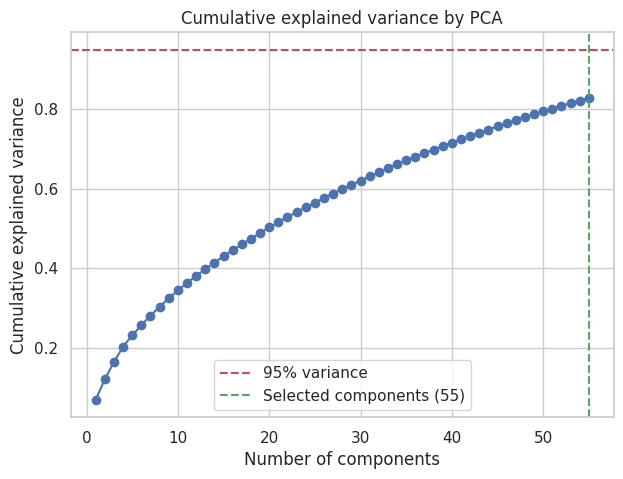

In [ ]:
# Cumulative explained variance by PCA
cum_var = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(cum_var) + 1), cum_var, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.axvline(x=n_components_selected, color='g', linestyle='--', label=f'Selected components ({n_components_selected})')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative explained variance by PCA')
plt.legend()
plt.grid(True)
plt.savefig('pca_cumulative_variance.png')

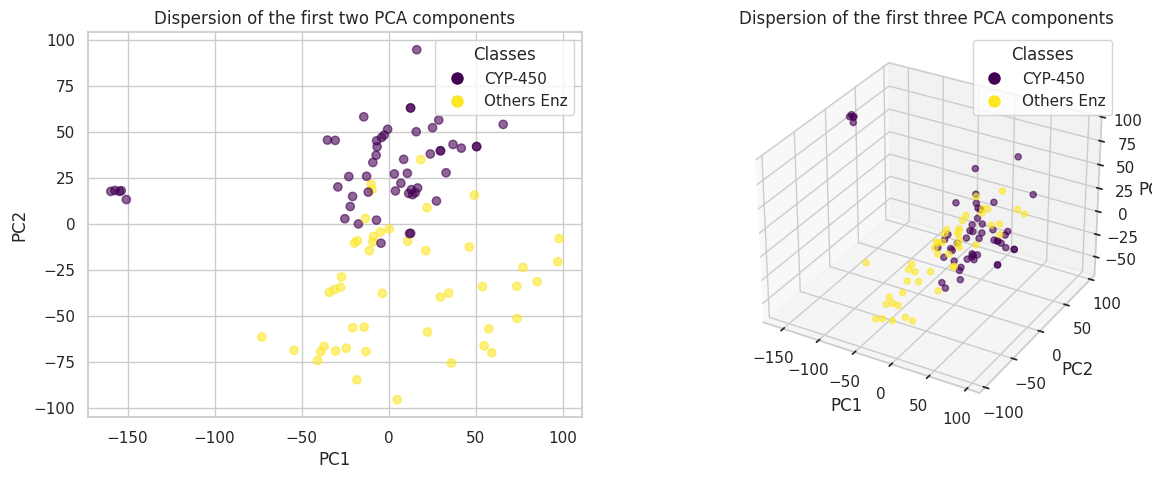

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

category_names = {1: 'CYP-450', 2: 'Others Enz'}

fig = plt.figure(figsize=(14, 5))

# subplot 1 left
ax1 = fig.add_subplot(121)
scatter = ax1.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', alpha=0.6)

handles = []
for category, name in category_names.items():
    handles.append(plt.Line2D([0], [0], marker='o', color='w', label=name,
                                markerfacecolor=scatter.cmap(scatter.norm(category)), markersize=10))

ax1.legend(handles=handles, title='Classes')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_title('Dispersion of the first two PCA components')
ax1.grid(True)

# subplot 2 right
ax2 = fig.add_subplot(122, projection='3d')
scatter_3d = ax2.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], c=y_train, cmap='viridis', alpha=0.6)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')
ax2.set_title('Dispersion of the first three PCA components')
ax2.legend(handles=handles, title='Classes')

# Save figure
plt.savefig('pca_scatter_plot.png')
plt.show()

In [ ]:
# Normalization of the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pca)
X_search_space_scaled = scaler.transform(X_search_space_pca)

In [ ]:
normalizer = Normalizer()
X_train_normalized = normalizer.fit_transform(X_train_pca)
X_search_space_normalized = normalizer.transform(X_search_space_pca)

#### Models

In [ ]:
import os
import sys

current_dir = os.getcwd()

if current_dir not in sys.path:
    sys.path.append(current_dir)

from utils.hyperparameter_optimizer import optimize_svm, optimize_nn, optimize_gbc

In [ ]:
def ESI_training_model(model, split_fraction, num_simulations, X_train_scaled, y_train, model_name):
    '''
      Function to evaluate an ML model using simulations. It calculates performance metrics such as accuracy, recall, and precision, and saves the trained model.

      Inputs
        model: ML model object; The model to be trained and evaluated (SVM, NN, GBC, meta_learner).
        split_fraction: Float; Proportion of the data to be used for cross-validation.
        num_simulations: Integer; Number of simulations to perform to evaluate the model. Each simulation involves splitting the data into training and validation sets.
        x_train_scaled: numpy.ndarray or pandas.DataFrame. Training feature set.
        y_train: numpy.ndarray or pandas.Series; Labels or target values ​​corresponding to x_train_scaled.
        model_name: String; Name of the model being evaluated, used for printing and saving the model.

      Outputs
        Return: Dict. Contains the model's average performance metrics, including:
          "accuracy": Average precision.
          "recall": Average recall.
          "precision": Average precision.
    '''
    print(f"Evaluating {model_name} with {num_simulations} simulations")
    accuracy_scores = []
    recall_scores = []
    precision_scores = []

    #Simulations
    for sim in range(num_simulations):
        # Split data into training and validation
        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train_scaled, y_train, test_size=split_fraction, random_state=sim
        )

        # Training
        model.fit(X_tr, y_tr)

        # Predict on the validation set
        y_pred = model.predict(X_val)

        # Metrics
        accuracy_scores.append(accuracy_score(y_val, y_pred))
        recall_scores.append(recall_score(y_val, y_pred, average='weighted'))
        precision_scores.append(precision_score(y_val, y_pred, average='weighted'))

    # Average metrics
    metrics = {
        "accuracy": np.mean(accuracy_scores),
        "recall": np.mean(recall_scores),
        "precision": np.mean(precision_scores)
    }

    # Train the model with all the data and save it
    model.fit(X_train_scaled, y_train)
    joblib.dump(model, f"{model_name.lower().replace(' ', '_')}_classifier.pkl")

    return metrics

##### Parameters

In [ ]:
num_sim = 1000 # 100
split_fraction = 0.1

#### Without hyperparameter optimization

##### Support Vector Machine

In [ ]:
SVM = SVC(
        C=5,              #Regularization parameter
        kernel='linear',     #kernel type
        gamma='scale',    #Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’
        probability=True, #Whether to enable probability estimates
        random_state=42   #seed
      )

In [ ]:
%%time
#metrics = ESI_training_model(SVM, split_fraction, num_sim,
#                                        X_train_normalized, y_train, 'SVM')
metrics = ESI_training_model(SVM, split_fraction, num_sim,
                                        X_train_scaled, y_train, 'SVM')
accuracy_svm = metrics["accuracy"]
recall_svm = metrics["recall"]
precision_svm = metrics["precision"]
print('********** Performance of SVM **************')
print(f' Accuracy:\t{accuracy_svm:.2f} \n Precision:\t{precision_svm:.2f} \n Recall:\t{recall_svm:.2f}')

Evaluating SVM with 100 simulations
********** Performance of SVM **************
 Accuracy:	0.82 
 Precision:	0.84 
 Recall:	0.82
CPU times: user 990 ms, sys: 4.01 ms, total: 994 ms
Wall time: 993 ms


##### Neural Network

In [ ]:
#NN = MLPClassifier(hidden_layer_sizes=(100,50), learning_rate_init=0.01, alpha=0.001,
#                       max_iter=500, random_state=42)
NN = MLPClassifier(
    hidden_layer_sizes=(100,50),    # layers
    learning_rate_init=0.01,      # Learning rate init
    learning_rate='adaptive',      # learning rate
    alpha=0.001,                  # regularization rate
    max_iter=200,                  # iterations
    solver='adam',                 # Solver
    activation='relu',             # Function activation
    random_state=42                # seed
)

In [ ]:
%%time
metrics = ESI_training_model(NN, split_fraction, num_sim,
                                        X_train_normalized, y_train, 'NN')
#metrics = ESI_training_model(NN, split_fraction, num_sim,
#                                        X_train_scaled, y_train, 'NN')
accuracy_nn = metrics["accuracy"]
recall_nn = metrics["recall"]
precision_nn = metrics["precision"]
print('********** Performance of NN **************')
print(f' Accuracy:\t{accuracy_nn:.2f} \n Precision:\t{precision_nn:.2f} \n Recall:\t{recall_nn:.2f}')

Evaluating NN with 100 simulations
********** Performance of NN **************
 Accuracy:	0.80 
 Precision:	0.82 
 Recall:	0.80
CPU times: user 3.71 s, sys: 11 ms, total: 3.72 s
Wall time: 3.69 s


##### Gradient Boosting

In [ ]:
#GBC = GradientBoostingClassifier(n_estimators=15, learning_rate=0.1, max_depth=3,
#                                     subsample=1, random_state=42)
GBC = GradientBoostingClassifier(
    n_estimators=5,              # Trees
    learning_rate=0.1,            # Learning rate
    max_depth=2,                   # depth tree
    subsample=1,                 # Subsample
    min_samples_split=3,           # Minimum number of samples to split
    min_samples_leaf=2,            # Minimum number of samples per leaf
    random_state=42
)

In [ ]:
%%time
#metrics = ESI_training_model(GBC, split_fraction, num_sim,
#                                        X_train_normalized, y_train, 'GBC')
metrics = ESI_training_model(GBC, split_fraction, num_sim,
                                        X_train_scaled, y_train, 'GBC')
accuracy_gbc = metrics["accuracy"]
recall_gbc = metrics["recall"]
precision_gbc = metrics["precision"]
print('********** Performance of GBC **************')
print(f' Accuracy:\t{accuracy_gbc:.2f} \n Precision:\t{precision_gbc:.2f} \n Recall:\t{recall_gbc:.2f}')

Evaluating GBC with 100 simulations
********** Performance of GBC **************
 Accuracy:	0.86 
 Precision:	0.87 
 Recall:	0.86
CPU times: user 1.78 s, sys: 14.9 ms, total: 1.8 s
Wall time: 1.79 s


##### Meta Learner

In [ ]:
meta_learner = VotingClassifier(
    estimators=[
        ('NN', NN),
        ('GBC', GBC),
        ('SVM', SVM)
    ],
    voting='soft'
)

In [ ]:
%%time
metrics = ESI_training_model(meta_learner, split_fraction, num_sim,
                                        X_train_normalized, y_train, 'Meta Learner')
#metrics = ESI_training_model(meta_learner, split_fraction, num_sim,
#                                        X_train_scaled, y_train, 'Meta Learner')
accuracy_ml = metrics["accuracy"]
recall_ml = metrics["recall"]
precision_ml = metrics["precision"]
print('********** Performance of Meta Learner **************')
print(f' Accuracy:\t{accuracy_ml:.2f} \n Precision:\t{precision_ml:.2f} \n Recall:\t{recall_ml:.2f}')

Evaluating Meta Learner with 100 simulations
********** Performance of Meta Learner **************
 Accuracy:	0.91 
 Precision:	0.92 
 Recall:	0.91
CPU times: user 24.8 s, sys: 89.7 ms, total: 24.9 s
Wall time: 25.8 s


In [ ]:
# Data
data = {
    'Model': ['SVM', 'NN', 'GBC', 'META'],
    'Accuracy': [accuracy_svm, accuracy_nn, accuracy_gbc, accuracy_ml],
    'Precision': [precision_svm, precision_nn, precision_gbc, precision_ml],
    'Recall': [recall_svm, recall_nn, recall_gbc, recall_ml]
}
df = pd.DataFrame(data)

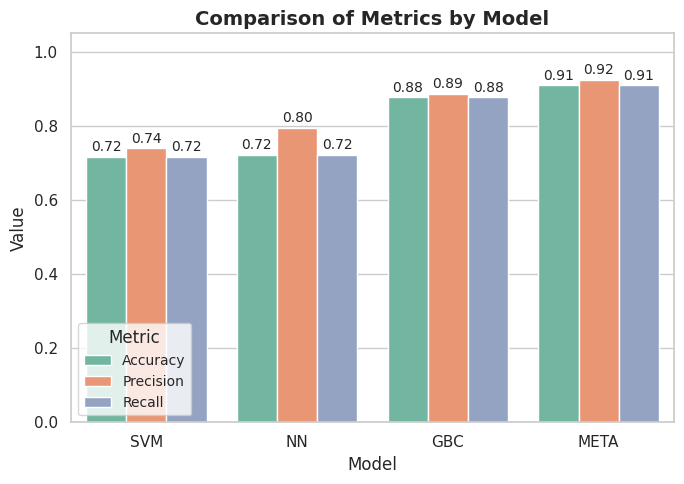

In [ ]:
sns.set(style="whitegrid")
df_long = df.melt(id_vars='Model', var_name='Metric', value_name='Value')

# bar chart
plt.figure(figsize=(7, 5))
ax = sns.barplot(data=df_long, x='Model', y='Value', hue='Metric', palette='Set2')

# labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=2, fontsize=10)

plt.title("Comparison of Metrics by Model", fontsize=14, fontweight='bold')
plt.ylim(0, 1.05)
plt.legend(title='Metric',loc='lower left', fontsize=10, title_fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.savefig('Comparison_of_Metrics_by_Model.png')
plt.show()

#### With hyperparameter optimization

##### SVM

In [ ]:
%%time
print("Optimizing SVM...")
best_svm, best_svm_params = optimize_svm(X_train_scaled, y_train)
print("Best parameters for SVM:", best_svm_params)

In [ ]:
%%time
metrics_best_svm = ESI_training_model(best_svm, split_fraction, num_simulations, X_train_scaled, y_train, 'SVM')
accuracy_best_svm = metrics_best_svm["accuracy"]
recall_best_svm = metrics_best_svm["recall"]
precision_best_svm = metrics_best_svm["precision"]
print('********** Performance of best SVM **************')
print(f' Accuracy:\t{accuracy_best_svm:.2f} \n Precision:\t{precision_best_svm:.2f} \n Recall:\t{recall_best_svm:.2f}')

##### NN

In [ ]:
%%time
print("Optimizing NN...")
best_nn, best_nn_params = optimize_nn(X_train_normalized, y_train)
print("Best parameters for NN:", best_nn_params)

In [ ]:
%%time
metrics_best_nn = ESI_training_model(best_nn, split_fraction, num_simulations, X_train_normalized, y_train, 'NN')
accuracy_best_nn = metrics_best_nn["accuracy"]
recall_best_nn = metrics_best_nn["recall"]
precision_best_nn = metrics_best_nn["precision"]
print('********** Performance of Best NN **************')
print(f' Accuracy:\t{accuracy_best_nn:.2f} \n Precision:\t{precision_best_nn:.2f} \n Recall:\t{recall_best_nn:.2f}')

##### GBC

In [ ]:
%%time
print("Optimizing GBC...")
best_gbc, best_gbc_params = optimize_gbc(X_train_scaled, y_train)
print("Best parameters for GBC:", best_gbc_params)

In [ ]:
%%time
metrics_best_gbc = ESI_training_model(best_gbc, split_fraction, num_simulations, X_train_scaled, y_train, 'GBC')
accuracy_best_gbc = metrics_best_gbc["accuracy"]
recall_best_gbc = metrics_best_gbc["recall"]
precision_best_gbc = metrics_best_gbc["precision"]
print('********** Performance of Best GBC **************')
print(f' Accuracy:\t{accuracy_best_gbc:.2f} \n Precision:\t{precision_best_gbc:.2f} \n Recall:\t{recall_best_gbc:.2f}')

##### Meta Learner

In [ ]:
%%time
meta_learner = VotingClassifier(
    estimators=[
        ('NN', best_nn),
        ('GBC', best_gbc),
        ('SVM', best_svm)
    ],
    voting='soft'
)

In [ ]:
%%time
metrics_best_ml = ESI_training_model(meta_learner, split_fraction, num_simulations, X_train_normalized, y_train, 'Meta Learner')
accuracy_best_ml = metrics_best_ml["accuracy"]
recall_best_ml = metrics_best_ml["recall"]
precision_best_ml = metrics_best_ml["precision"]
print('********** Performance of Best Meta Learner **************')
print(f' Accuracy:\t{accuracy_best_ml:.2f} \n Precision:\t{precision_best_ml:.2f} \n Recall:\t{recall_best_ml:.2f}')

In [ ]:
# Data
data_best = {
    'Model': ['Best SVM', 'Best NN', 'Best GBC', 'Best META'],
    'Accuracy': [accuracy_best_svm, accuracy_best_nn, accuracy_best_gbc, accuracy_best_ml],
    'Precision': [precision_best_svm, precision_best_nn, precision_best_gbc, precision_best_ml],
    'Recall': [recall_best_svm, recall_best_nn, recall_best_gbc, recall_best_ml]
}
dfb = pd.DataFrame(data_best)

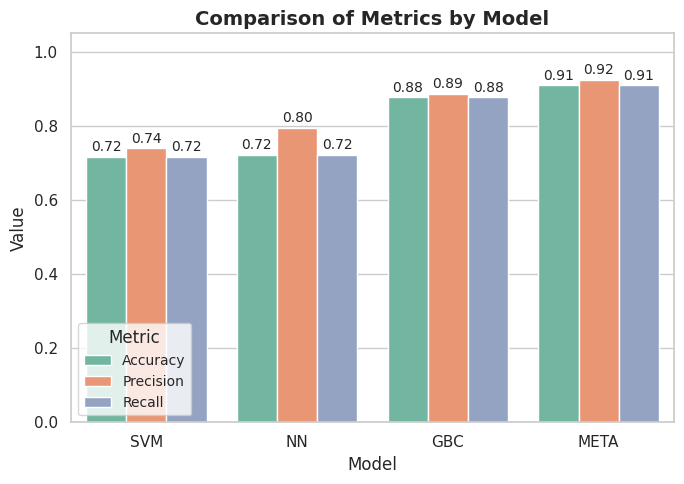

In [ ]:
sns.set(style="whitegrid")
df_long_best = dfb.melt(id_vars='Model', var_name='Metric', value_name='Value')

# bar chart
plt.figure(figsize=(7, 5))
ax = sns.barplot(data=df_long_best, x='Model', y='Value', hue='Metric', palette='Set2')

# labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=2, fontsize=10)

plt.title("Comparison of Metrics of Best Models", fontsize=14, fontweight='bold')
plt.ylim(0, 1.05)
plt.legend(title='Metric',loc='lower left', fontsize=10, title_fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.savefig('Comparison_of_Metrics_of_Best_Models.png')
plt.show()

## Predictions

In [ ]:
#predictions = meta_learner.predict(X_search_space_scaled)
#predictions = meta_learner.predict(X_search_space_normalized)
#predictions = GBC.predict(X_search_space_scaled)
#predictions = GBC.predict(X_search_space_normalized)
#predictions = NN.predict(X_search_space_scaled)
#predictions = NN.predict(X_search_space_normalized)
#predictions = SVM.predict(X_search_space_scaled)
predictions = SVM.predict(X_search_space_normalized)

In [ ]:
predictions_df = pd.DataFrame({
    "enz_alias": search_space_enz_names,
    "prediction": predictions
})
predictions_df.to_excel("predictions.xlsx", index=False)

In [ ]:
pred=predictions_df[predictions_df['prediction']==1]
df_out=pd.read_csv('./analysis/mappings/search_space_enz_map.csv',header=None, names=['alias','name'])
pred=df_out[df_out['alias'].isin(pred['enz_alias'])]
print(f'Number of enzymes of interest: {len(pred)}')
pred

Number of enzymes of interest: 69


,alias,name
0,search_space_enz_0,sp|O22781|SUVH2_ARATH
1,search_space_enz_1,sp|O95050|INMT_HUMAN
2,search_space_enz_2,sp|P10937|PNMT_RAT
3,search_space_enz_3,sp|P21964|COMT_HUMAN
4,search_space_enz_4,sp|P22061|PIMT_HUMAN
...,...,...
90,search_space_enz_90,sp|Q99LB7|SARDH_MOUSE
91,search_space_enz_91,sp|Q9AGP0|TSOXG_ARTSP
92,search_space_enz_92,sp|Q9AGP1|TSOXA_ARTSP
93,search_space_enz_93,sp|Q9AGP2|TSOXD_ARTSP


In [ ]:
print('Enzymes of interest')
for nam in pred['name']:
    print(f"Full Name: {nam}")

Enzymes of interest
Full Name: sp|O22781|SUVH2_ARATH
Full Name: sp|P46959|TRM61_YEAST
Full Name: sp|Q15910|EZH2_HUMAN
Full Name: sp|Q7Z4G4|TRM11_HUMAN
Full Name: sp|Q9BV44|THUM3_HUMAN
Full Name: sp|Q9UBL3|ASH2L_HUMAN
Full Name: sp|Q9Y6K1|DNM3A_HUMAN
Full Name: sp|protein|C96T_
Full Name: sp|P52788|SPSY_HUMAN
Full Name: sp|Q1QAX7|CYSG_PSYCK
Full Name: sp|Q42606|UPM1_ARATH
Full Name: sp|Q4FSU1|CYSG_PSYA2
Full Name: sp|Q59292|HEMA_RUMJO
Full Name: sp|Q7VQG9|CYSG_BLOFL
Full Name: sp|P46059|S15A1_HUMAN
Full Name: sp|Q1QYW1|DDHC_CHRSD
Full Name: sp|Q495M3|S36A2_HUMAN
Full Name: sp|Q50LF0|TSOXA_CORS9
Full Name: sp|Q63342|M2GD_RAT
Full Name: sp|Q64380|SARDH_RAT
Full Name: sp|Q8BHK3|S36A2_MOUSE
Full Name: sp|Q8IY34|S15A3_HUMAN
Full Name: sp|Q8K415|S36A2_RAT
Full Name: sp|Q9NP91|S6A20_HUMAN
Full Name: sp|Q9UI17|M2GD_HUMAN
Full Name: sp|Q9UL12|SARDH_HUMAN
Full Name: sp|Q46337|TSOXA_CORS1
Full Name: sp|Q47878|GRDD_PEPAC
Full Name: sp|O87386|TSOXA_RHIME
Full Name: sp|Q52671|TSOXB_RHOCB
Full Name: s